In [1]:
import numpy as np
import glob
import xarray as xr
import netCDF4

import matplotlib.pyplot as plt

# CPOL convenience functions
import CPOL_func as cf


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/563/esh563/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/563/esh563/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [158]:
a = np.load('/g/data/w40/esh563/d04_lon_stag.npy')
b = np.load('/g/data/w40/esh563/d05_lon_stag.npy')

In [ ]:
len(a)

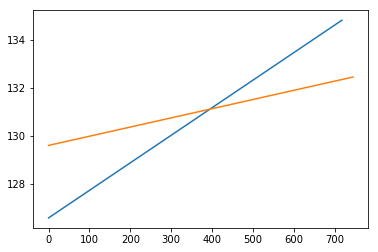

In [120]:
plt.plot(a)
plt.plot(b)

In [ ]:
a_sub = a[263:512]

In [ ]:
len(a_sub)

In [164]:
len(a_sub)
# -12.249167
131.044444
a_sub[126]
a_sub_sub = a_sub[4:-4]
len(a_sub_sub)
a_sub_sub[121]
np.save('/g/data/w40/esh563/dbz_lon', a_sub_sub)

In [163]:
len(a_sub_sub)

241

In [140]:
print(b[-1])
print(a[511])

132.44519
132.4452


In [39]:
check = np.load('/g/data/w40/esh563/lind04/dbz/2006-02-09_00:50:00alllevels_zlib.npy')

In [41]:
check.shape

(40, 241, 241)

In [37]:
416.6667 * 3

1250.0001

In [3]:
hgt_AGL = np.load('/g/data/w40/esh563/d04_hgt_AGL.npy')

In [21]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

np.round(moving_average(hgt_AGL, n=2))

array([2.3000e+01, 6.8000e+01, 1.1300e+02, 1.5800e+02, 2.0300e+02,
       2.4900e+02, 2.9500e+02, 3.4100e+02, 3.8700e+02, 4.3300e+02,
       5.0300e+02, 5.9700e+02, 6.9100e+02, 7.8600e+02, 8.8200e+02,
       9.7900e+02, 1.0760e+03, 1.1750e+03, 1.2740e+03, 1.3740e+03,
       1.4750e+03, 1.6290e+03, 1.8370e+03, 2.0490e+03, 2.2660e+03,
       2.4870e+03, 2.7130e+03, 2.9440e+03, 3.1800e+03, 3.4220e+03,
       3.6690e+03, 3.9230e+03, 4.1830e+03, 4.4490e+03, 4.7240e+03,
       5.0060e+03, 5.2960e+03, 5.5960e+03, 5.9050e+03, 6.2250e+03,
       6.5570e+03, 6.9000e+03, 7.2570e+03, 7.6280e+03, 8.0140e+03,
       8.4170e+03, 8.8370e+03, 9.2770e+03, 9.7390e+03, 1.0225e+04,
       1.0739e+04, 1.1284e+04, 1.1866e+04, 1.2490e+04, 1.3165e+04,
       1.3899e+04, 1.4706e+04, 1.5609e+04, 1.6645e+04, 1.7897e+04,
       1.9552e+04, 2.2042e+04, 2.6775e+04])

In [2]:
test0 = xr.open_mfdataset('/g/data/w40/esh563/d05.dir/wrfout_d05_2006-02-09_00:00:00.nc.gz')

In [13]:
test0

<xarray.Dataset>
Dimensions:              (Time: 3, bottom_top: 63, bottom_top_stag: 64, south_north: 744, south_north_stag: 745, west_east: 744, west_east_stag: 745)
Coordinates:
    XLAT                 (Time, south_north, west_east) float32 -13.643532 ... -10.866936
    XLONG                (Time, south_north, west_east) float32 129.60164 ... 132.44328
    XLAT_U               (Time, south_north, west_east_stag) float32 dask.array<chunksize=(3, 744, 745), meta=np.ndarray>
    XLONG_U              (Time, south_north, west_east_stag) float32 dask.array<chunksize=(3, 744, 745), meta=np.ndarray>
    XLAT_V               (Time, south_north_stag, west_east) float32 dask.array<chunksize=(3, 745, 744), meta=np.ndarray>
    XLONG_V              (Time, south_north_stag, west_east) float32 dask.array<chunksize=(3, 745, 744), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times     

In [20]:
test00=test0.XLONG.load()
d05_lon = np.array(test00[0,0,:])
np.save('/g/data/w40/esh563/d05_lon.npy', d05_lon) 

In [21]:
d05_lat = np.load('/g/data/w40/esh563/d05_lat.npy') 
d05_lon = np.load('/g/data/w40/esh563/d05_lon.npy') 
d05_lat_stag = np.load('/g/data/w40/esh563/d05_lat_stag.npy') 
d05_lon_stag = np.load('/g/data/w40/esh563/d05_lon_stag.npy') 

In [26]:
744/3

248.0

In [28]:
print(len(d05_lon))
d05_lon

744


array([129.60164, 129.60547, 129.60928, 129.61311, 129.61694, 129.62076,
       129.62459, 129.62842, 129.63223, 129.63606, 129.63988, 129.6437 ,
       129.64754, 129.65135, 129.65518, 129.65901, 129.66283, 129.66666,
       129.67049, 129.6743 , 129.67813, 129.68196, 129.68578, 129.6896 ,
       129.69344, 129.69725, 129.70108, 129.7049 , 129.70872, 129.71255,
       129.71637, 129.7202 , 129.72403, 129.72784, 129.73167, 129.7355 ,
       129.73932, 129.74315, 129.74698, 129.7508 , 129.75462, 129.75845,
       129.76227, 129.7661 , 129.76991, 129.77374, 129.77757, 129.78139,
       129.78522, 129.78905, 129.79286, 129.79669, 129.80052, 129.80434,
       129.80817, 129.812  , 129.81581, 129.81964, 129.82346, 129.82729,
       129.83112, 129.83493, 129.83876, 129.84259, 129.8464 , 129.85023,
       129.85406, 129.85788, 129.86171, 129.86554, 129.86935, 129.87318,
       129.87701, 129.88083, 129.88466, 129.88847, 129.8923 , 129.89613,
       129.89995, 129.90378, 129.90761, 129.91142, 

In [101]:
test2 = xr.open_dataset('/g/data/w40/esh563/lind04/dbz/2006-02-09_00:00:00alllevels_zlib.nc')

In [145]:
test2.radar_longitude

<xarray.DataArray 'radar_longitude' (nradar: 1)>
array([131.044444])
Dimensions without coordinates: nradar
Attributes:
    long_name:  Longitude of radars used to make the grid.
    units:      degrees_east

In [30]:
test = xr.open_mfdataset('/g/data/w40/esh563/d04.dir/wrfout_d04_2006-02-09_00:00:00.nc.gz')

In [33]:
test['bottom_top'] =  np.round(moving_average(hgt_AGL, n=2))

In [34]:
test['bottom_top_stag'] = np.round(hgt_AGL)

In [43]:
test.U[0,:,0,:].plot()

NameError: name 'test' is not defined

In [36]:
test00=test.XLONG_U.load()
d04 = np.array(test00[0,0,:])
np.save('/g/data/w40/esh563/d04_lon_stag.npy', d04) 

In [33]:
test

<xarray.Dataset>
Dimensions:              (Time: 3, bottom_top: 63, bottom_top_stag: 64, south_north: 486, south_north_stag: 487, west_east: 717, west_east_stag: 718)
Coordinates:
    XLAT                 (Time, south_north, west_east) float32 -14.296738 ... -8.847343
    XLONG                (Time, south_north, west_east) float32 126.58789 ... 134.80304
    XLAT_U               (Time, south_north, west_east_stag) float32 dask.array<chunksize=(3, 486, 718), meta=np.ndarray>
    XLONG_U              (Time, south_north, west_east_stag) float32 dask.array<chunksize=(3, 486, 718), meta=np.ndarray>
    XLAT_V               (Time, south_north_stag, west_east) float32 dask.array<chunksize=(3, 487, 717), meta=np.ndarray>
    XLONG_V              (Time, south_north_stag, west_east) float32 dask.array<chunksize=(3, 487, 717), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times      